In [1]:
%matplotlib inline

In [2]:
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import binned_statistic

In [3]:
image_filename = 'file.fits' #'test_ellipse_200_40.fits'

In [4]:
with pyfits.open(image_filename) as fits_file:
    enshift = np.array(fits_file['ENSHIFT'].data)    # energy shift from each pixel to observer
    disc_r = np.array(fits_file['RADIUS'].data)      # radius on the disc seen in each pixel
    
enshift[np.isnan(enshift)] = 0

In [5]:
## this is just to define a colourmap to nicely show the disc energy shift
# normalisation for redshift
redshift_vmin = 0.01
redshift_vmax = 1.2
redshift_normpl = 1.
redshift_norm = colors.Normalize(redshift_vmin, redshift_vmax)
# colour map for redshift
redshift_cdict = {'blue': [(0.0, 0, 0),
                           (0.35, 0, 0),
                           (0.8, 0, 0),
                           (0.97, 1, 1),
                           (1.0, 0.6, 0.6)],
                  'green': [(0.0, 0, 0),
                            (0.2, 0, 0),
                            (0.6, 1, 1),
                            (0.75, 1, 1),
                            (0.8, 0.75, 0.75),
                            (0.85, 1.0, 1.0),
                            (0.93, 1.0, 1.0),
                            (0.99, 0, 0),
                            (1.0, 0, 0)],
                  'red': [(0.0, 0, 0),
                          (0.001, 0.5, 0.5),
                          (0.2, 1, 1),
                          (0.7, 1, 1),
                          (0.8, 0, 0),
                          (1.0, 0, 0)]}
redshift_map = colors.LinearSegmentedColormap('RedshiftMap', redshift_cdict)

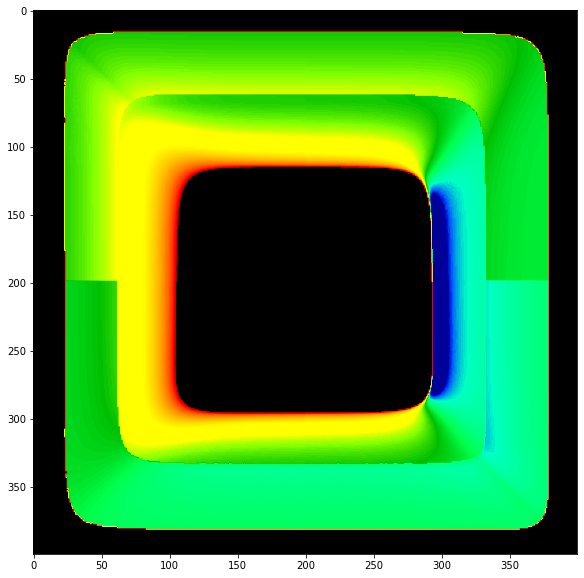

In [6]:
# plot the energy shift as a function of position in the image
plt.figure(figsize=(10,10))
plt.imshow(np.flipud(enshift), norm=redshift_norm, cmap=redshift_map)

In [7]:
# emissivity profile - the luminoisty of each patch of the disc, measured in
# its own rest frame

# we'll use a broken power law
def broken_pl(r, q1, rbreak, q2):
    pl = np.zeros_like(r)
    pl[r <= rbreak] = r[r<=rbreak]**-q1
    pl[r > rbreak] = rbreak**(q2-q1) * r[r>rbreak]**-q2
    return pl

disc_emis = broken_pl(disc_r, 3, 5, 3)

<ipython-input-7-9f6dcd589f81>:7: RuntimeWarning: divide by zero encountered in power
  pl[r <= rbreak] = r[r<=rbreak]**-q1


In [8]:
# flux image of the disc - flux from each patch of the disc is proportional to redshift**3,
# multiplied by the local emissivity of that patch
disc_flux = disc_emis * enshift**3
disc_flux[np.isnan(disc_flux)] = 0

<ipython-input-8-0fe5e3e76baa>:3: RuntimeWarning: invalid value encountered in multiply
  disc_flux = disc_emis * enshift**3


In [9]:
# uncomment these lines to truncate the inner edge of the disc
#r_in = 1.5
#disc_flux[disc_r<r_in] = 0

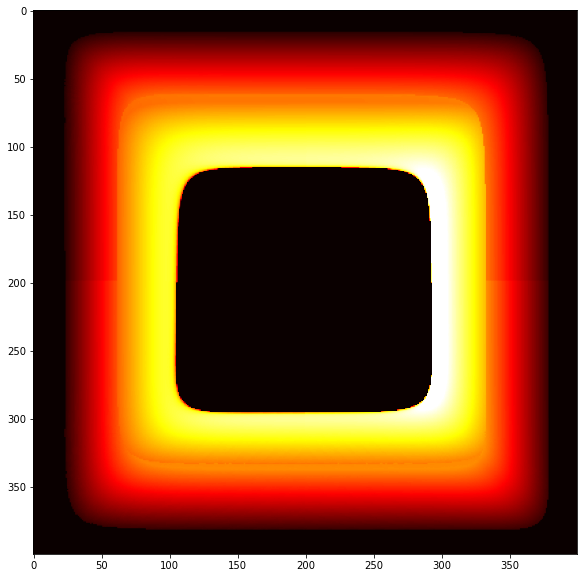

In [10]:
# plot the flux image
flux_min, flux_max = 1e-6*np.max(disc_flux), 0.1*np.max(disc_flux)
plt_disc_flux = np.array(disc_flux)
plt_disc_flux[disc_flux < flux_min] = flux_min
plt.figure(figsize=(10,10))
plt.imshow(np.flipud(plt_disc_flux), norm=colors.LogNorm(flux_min, flux_max), cmap='hot')

In [11]:
# build a line profile by summing up the flux from pixels in the image
# binning the pixels by energy

# rest frame line energy
line_en = 6.4

# edges of the spectral bins
bin_edges = np.arange(1,10,0.1)

# sum up the flux in each bin
line, en_edges, _ = binned_statistic(line_en*enshift.flatten(), disc_flux.flatten()
                                     , statistic='sum', bins=bin_edges)

# work out the mid point of each energy bin from the edges
energy = 0.5*(en_edges[1:] + en_edges[:-1])

Text(0, 0.5, 'Count Rate')

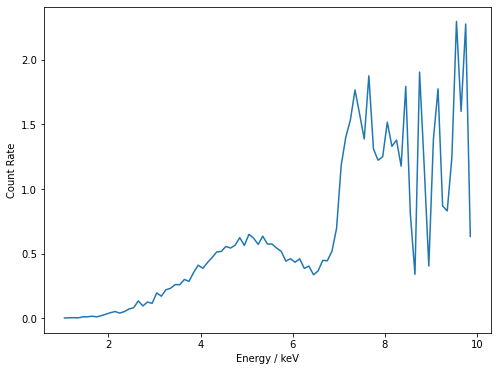

In [12]:
# plot the line
plt.figure(figsize=(8,6))
plt.plot(energy, line)
plt.xlabel('Energy / keV')
plt.ylabel('Count Rate')